In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 
!tar xzvf food-101.tar.gz

--2024-03-26 04:42:29--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-03-26 04:42:29--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: 'food-101.tar.gz.1'

food-101.tar.gz.1     4%[                    ] 233.01M  22.8MB/s    eta 3m 44s ^C
food-101/
food-101/images/
food-101/images/beignets/
food-101/images/beignets/2885220.jpg
food-101/images/beignets/1814040.jpg
food-101/images/beignets/81202.jpg
food-101/images/beignets/1827892.jpg
food-101/images/beignets/28

In [10]:
!pip install seaborn
!pip install opencv-python
!pip install scikit-image

import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

%cd content/

%matplotlib inline

  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/33/29/1d696450464d6e13358d3ef185a1fb14a11181c5dab1eb2837c02be86373/scikit_image-0.21.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/02/25/66533a8390e3763cf8254dee143dbf8a830391ea60d2762512ba7f9ddfbe/imageio-2.34.0-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/06/a3/68d17088a4f09565bc7341fd20490da8191ec4cddde479daaabbe07bb603/tifffile-2023.7.10-py3-none-any.whl.metadata
  Obtaining dependency information for PyWavelets>=1.1.1 from https://files.pythonhosted.org/packages/88/4b/b2b2a6f51e47c091c221bfde976a01a7e5f20e7e5e6341b2b9c4db73d2ed/PyWavelets-1.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for lazy_loader>=0.2 from https://files.p

In [11]:
class_N = {}
N_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map. 
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# Method to recursively copy a directory.  
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore. 
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.    
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.  
def load_images(path_to_imgs):
  resize_count = 0
  
  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)
  
  return np.array(all_imgs), np.array(all_classes)

# Method to generate train-test files. 
def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test


{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [18]:
import os

# Function to generate train-test split
def gen_train_test_split():
    # Your code for generating train-test split goes here
    # Example: Splitting files into train and test folders
    source_dir = './food-101/images'
    train_dir = './food-101/train'
    test_dir = './food-101/test'
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # Assume images are already named appropriately for classification
    # Example: moving 80% of images to train and 20% to test
    files = os.listdir(source_dir)
    num_train = int(0.8 * len(files))
    train_files = files[:num_train]
    test_files = files[num_train:]

    # Move files to train and test folders
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Check if train and test folders exist, create if not
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    os.makedirs('./food-101/test')
    os.makedirs('./food-101/train')
    gen_train_test_split()
    len_train = len(os.listdir('./food-101/train'))
    len_test = len(os.listdir('./food-101/test'))
    print(len_train, len_test)
else:
    print('Train and test folders already exist.')
    len_train = len(os.listdir('./food-101/train'))
    len_test = len(os.listdir('./food-101/test'))
    print(len_train, len_test)


Train and test folders already exist.
101 101


In [19]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [28]:
# import matplotlib.pyplot as plt
# from skimage.io import imread

# # Provide the correct file path to the image
# testImg = imread('sagemaker-studiolab-notebooks/food-101/test/garlic_bread/2370539.jpg')
# print(testImg.shape)
# plt.imshow(testImg)
# plt.axis('off')  # Turn off axis labels
# plt.show()


In [1]:
from sklearn.model_selection import train_test_split

def load_train_test_data(train_dir, test_dir):
    # Load data from train_dir and test_dir
    # Example code to load data and split into X_train, y_train, X_test, y_test
    # Replace this with your actual implementation
    X_train = [...]  # Load training data
    y_train = [...]  # Load training labels
    X_test = [...]   # Load test data
    y_test = [...]   # Load test labels

    return X_train, y_train, X_test, y_test

# Example usage
train_dir = '/content/food-101/train'
test_dir = '/content/food-101/test'
X_train, y_train, X_test, y_test = load_train_test_data(train_dir, test_dir)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


tf.keras.backend.clear_session()

# Defining constants and parameters
n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = './food-101/train' 
test_data = './food-101/test'  
train_samples = 75750
test_samples = 13150

# Data generators for training and testing
train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')
test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

# Load InceptionV3 model without top layers
inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(0.2)(layer)

# Add output layer for classification
predictions = Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.005), activation='softmax')(layer)

# Create the model
model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for model checkpoint and CSV logging
checkpointer = ModelCheckpoint(filepath='best_model_101class_2.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

# Train the model
history_101class = model.fit(train_gen, steps_per_epoch=train_samples // batch_size, 
                             validation_data=test_gen, validation_steps=test_samples // batch_size, 
                             epochs=30, callbacks=[csv_logger, checkpointer])

# Save the trained model
model.save('model_trained_101class_2.hdf5')


Found 75750 images belonging to 101 classes.
Found 25257 images belonging to 101 classes.


Epoch 1/30
3051/4734 [==================>...........] - ETA: 4:48 - loss: 3.9198 - accuracy: 0.1479

In [4]:
class_map_101 = train_gen.class_indices
class_map_101


{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

/tmp/ipykernel_190/2305927364.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


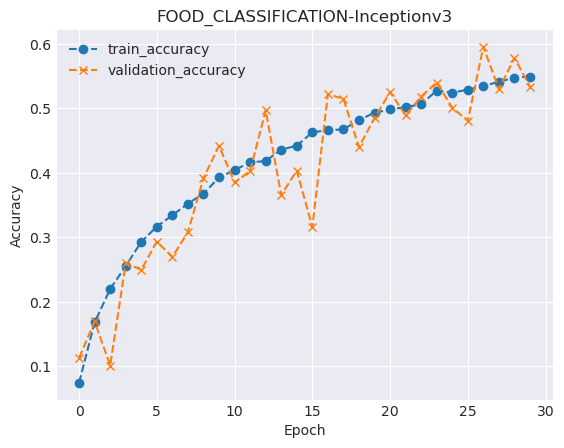

In [5]:
# Plot training-accuracy & validation-accuracy.
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

plt.title('FOOD_CLASSIFICATION-Inceptionv3')

plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')

plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')

plt.show()


/tmp/ipykernel_190/1208318546.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


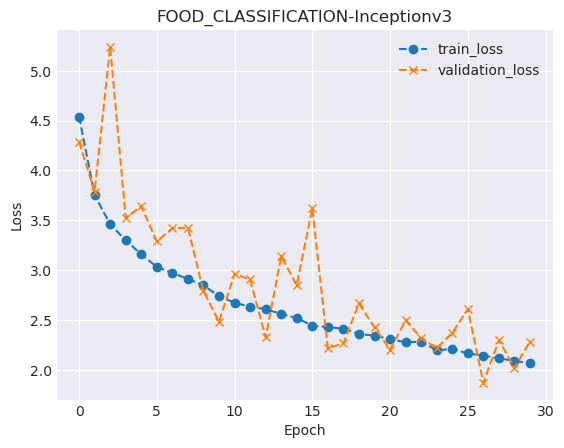

In [6]:
# Plot training-loss & validation-loss.
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

plt.title('FOOD_CLASSIFICATION-Inceptionv3')

plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')

plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['train_loss', 'validation_loss'], loc='best')

plt.show()


Enter the path to your image:  2177928.jpg


1/1 [==============================] - 2s 2s/step


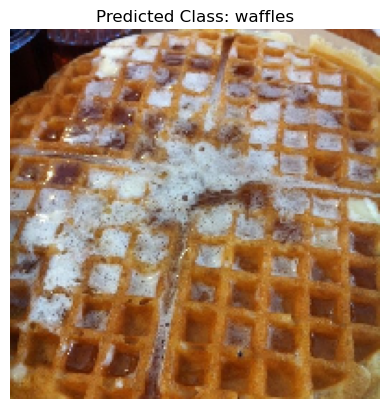

Nutrients for waffles:
Unnamed: 0        100
protein          2.86
calcium           0.0
fat              10.0
carbohydrates    48.6
vitamins          0.0
Name: 100, dtype: object


In [11]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model  

class_labels = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']  

model = load_model('best_model_101class.hdf5')

def predict_class_and_nutrients(model, img_path, nutrition_file):
  """Predicts the class of an image, retrieves nutrients, and displays the results."""
  # Image prediction
  img = image.load_img(img_path, target_size=(200, 200))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img / 255.0

  pred = model.predict(img)
  index = np.argmax(pred)
  predicted_class_name = class_labels[index]

  # Load nutrition data from CSV
  nutri_data = pd.read_csv(nutrition_file)

  # Find matching nutrients based on predicted class (assuming a 'class' column)
  try:
      nutrients = nutri_data[nutri_data['class'] == predicted_class_name].iloc[0]  
      nutrients = nutrients.drop('class')  
  except IndexError:
      nutrients = "No matching nutrients found in the data."

  # Display image and results
  plt.imshow(img[0])
  plt.axis('off')
  plt.title(f"Predicted Class: {predicted_class_name}")
  plt.show()

  print(f"Nutrients for {predicted_class_name}:")
  if isinstance(nutrients, pd.DataFrame):  # Check if it's a DataFrame before iterating
      for nutrient, value in nutrients.items():
          print(f"\t{nutrient}: {value}")
  else:
      print(nutrients) 

img_path = input("Enter the path to your image: ")
nutrition_file = ("nutrition101.csv")

predict_class_and_nutrients(model, img_path, nutrition_file)


In [1]:
from keras.models import load_model

model = load_model('best_model_101class.hdf5')


2024-04-16 05:42:31.769882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Save model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")


In [3]:
import pickle

model_data = {}

with open('model_architecture.json', 'r') as json_file:
    model_data['architecture'] = json_file.read()

with open('model_weights.h5', 'rb') as weights_file:
    model_data['weights'] = weights_file.read()

with open('model.pkl', 'wb') as pickle_file:
    pickle.dump(model_data, pickle_file)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

hdf5_model_path = 'best_model_101class.hdf5'
model = load_model(hdf5_model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = 'best_model_101class.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_model_path}")


2024-04-24 09:15:54.599021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-04-24 09:16:06.958739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmp038ied6s/assets


INFO:tensorflow:Assets written to: /tmp/tmp038ied6s/assets
2024-04-24 09:16:37.383294: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-24 09:16:37.383356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-24 09:16:37.383644: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp038ied6s
2024-04-24 09:16:37.434417: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-24 09:16:37.434461: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp038ied6s
2024-04-24 09:16:37.602454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-04-24 09:16:37.686929: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-04-24 09:16:39.884715: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

TFLite model saved to best_model_101class.tflite
